# AIRS channel selection

Calculate trends for each AIRS channel.

Create infrastructure for easy spatial correlations between AIRS trends and other variables (to select representative channels). This will require a flexible/intelligent interpolation choice.

Consider doing correlations between variables/obs instead of trends (more robust likely).

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob, copy
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    stats, plot_trends, MidpointNormalize
    )

import copy
from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define function for computing trends

#### New slower function that uses scipy.stats.linregress via apply_ufunc and gets info on statistical significance

In [2]:
def linregress2(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

In [3]:
def vectorized_linregress2(data):
    '''
    Package for vectorized linregress call from: 
    https://stackoverflow.com/questions/52094320/with-xarray-how-to-parallelize-1d-operations-on-a-multidimensional-dataset. 
    Not very general.
    '''
    
    regressed_month = xr.apply_ufunc(
        linregress2, data['year'], data,
        input_core_dims=[['year'], ['year']],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=['float64'],
        output_sizes={"parameter": 5},
                      )
    
    return regressed_month

In [69]:
def compute_trends_n_signif2(subset_data):
    '''
    Package the trend calculating lines to save space. V2 uses vectorized_linregress2
    '''
    # create empty arrays for needed output
    _trends = xr.zeros_like(subset_data.groupby('time.month').mean('time')).load()
    _rvalues = _trends.copy()
    _pvalues = _trends.copy()

    # Potentially I should be able to format this to avoid this for loop too
    for i,_month in subset_data.groupby('time.month'):
#         print(i,end='')

        _yearlydata = _month.groupby('time.year').mean('time').chunk({'year': -1}) # let the other dimensions chunk however?
        regressed_month = vectorized_linregress2(_yearlydata)

        ii = i-1 # the count starts at month 1 (January) but we need to index starting at 0
        
        _trends[ii] = regressed_month.isel(parameter=0)
        _rvalues[ii] = regressed_month.isel(parameter=2)
        _pvalues[ii] = regressed_month.isel(parameter=3)

    # Calculate statistical significance
    N = len(_yearlydata.year)
    dof=N-2

    tcrit=stats.t.ppf(0.975,dof)  ## two-sided 95%
    t=_rvalues*np.sqrt(N-2)/np.sqrt((1-_rvalues*_rvalues))

    _statsig=(1-_pvalues)*100
    _notnull = t > tcrit # disproving the null hypothesis (slope is zero)    
    
    return _trends,_statsig,_notnull

## Create AIRS spectral trends file

In [42]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)

airs_files.sort()

Open all files together.

In [93]:
all_airs = xr.open_mfdataset(airs_files,parallel=True)

Take even years 2003-2018 (16 total).

Select the Arctic, and weight the ascending and descending orbits equally.

#### These calculation required ~3 gb of memory (I ran with 4)

In [8]:
if os.path.exists('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/')):
    all_data_spec_olr = xr.open_dataset('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
else:
    # Subset for efficiency
    olr_subset = all_airs['olr_spectral'].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass')
    
    # Calculate trends after averaging over longitudes
    _trends_spec_olr,_statsig_spec_olr,_notnull_spec_olr = compute_trends_n_signif2(olr_subset.mean(dim='lon'))
    
    # Combine into a single file and save
    all_data_spec_olr = xr.merge([_trends_spec_olr.rename('TREND'),_statsig_spec_olr.rename('STATSIG'),_notnull_spec_olr.rename('NOTNULL')])
    all_data_spec_olr.to_netcdf('%s/%s/olr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))    

In [9]:
if os.path.exists('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/')):
    all_data_spec_olr_clr = xr.open_dataset('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))
else:
    # Subset for efficiency
    olr_clr_subset = all_airs['olr_clr_spectral'].sel(lat=slice(59,None),time=slice('2003-01-01','2018-12-31')).mean(dim='orbit_pass')

    # Calculate trends after averaging over longitudes
    _trends_spec_olr_clr,_statsig_spec_olr_clr,_notnull_spec_olr_clr = compute_trends_n_signif2(olr_clr_subset.mean(dim='lon'))
    
    # Combine into a single file and save
    all_data_spec_olr_clr = xr.merge([_trends_clr.rename('TREND'),_statsig_clr.rename('STATSIG'),_notnull_clr.rename('NOTNULL')])
    all_data_spec_olr_clr.to_netcdf('%s/%s/olr_clr_spectral_trends_lonavg.nc' % (airs_dir,'arc_proc/'))

#### Correlate individual channels

This is a first step before correlating spectral channels (trends) with observations (trends)

Create masked arrays (either using a where statement or the numpy.ma subpackage.

In [10]:
def calculate_spatial_correlation(cntl,test):
    """
    Calculate the spatial correlation coefficient for two xarray dataarrays, weighting by gridcell area.
    Values marked with a Nan are mutually masked.
    """
    
    _cntl = add_weights(cntl)
       
    mask = np.bitwise_or(xr.ufuncs.isnan(cntl),xr.ufuncs.isnan(test)) # mask means hide
    
    wgt = np.array(_cntl['cell_weight'])
    wgt = np.where(~mask,wgt,np.nan) # erroring
    
    sumwgt = np.nansum(wgt)
        
    # calculate means
    meantest = np.nansum(wgt*test)/sumwgt
    meancntl = np.nansum(wgt*cntl)/sumwgt

    # calculate variances
    stdtest = (np.nansum(wgt*(test-meantest)**2.0)/sumwgt)**0.5
    stdcntl = (np.nansum(wgt*(cntl-meancntl)**2.0)/sumwgt)**0.5

    # calculate correlation coefficient
    ccnum = np.nansum(wgt*(test-meantest)*(cntl-meancntl))
    ccdem = sumwgt*stdtest*stdcntl
    corr = ccnum/ccdem
    
    return corr

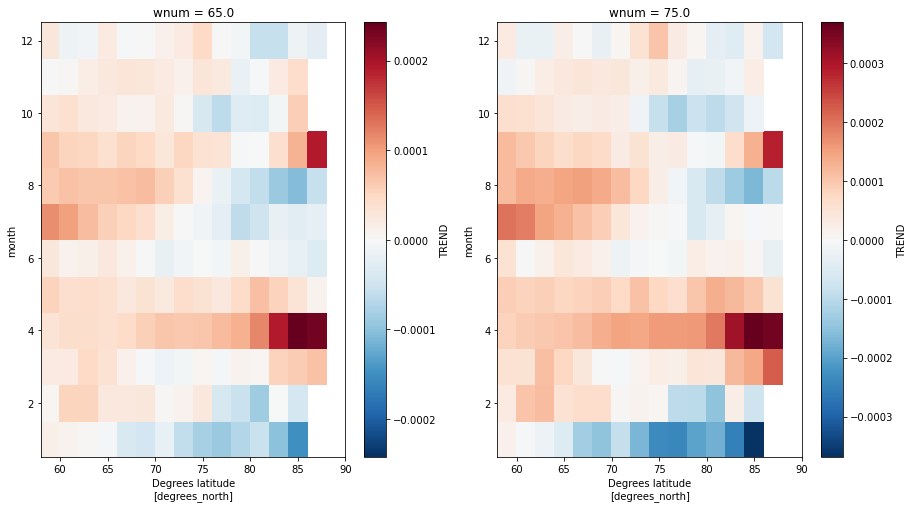

In [12]:
fig_t,axs_t = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

all_data_spec_olr_clr['TREND'][:,5,:].plot(ax=axs_t[0])
all_data_spec_olr_clr['TREND'][:,6,:].plot(ax=axs_t[1])

In [14]:
calculate_spatial_correlation(all_data_spec_olr_clr['TREND'][:,5,:],all_data_spec_olr_clr['TREND'][:,6,:])

0.9521779096529754

In [15]:
calculate_spatial_correlation(all_data_spec_olr_clr['TREND'][:,6,:],all_data_spec_olr_clr['TREND'][:,6,:])

1.0000000261391122

This all looks good. There seems to be a small rounding error somewhere in the code, but it is less than a part in a million.

## Test spatial correlations with GISStemp data

The GISS record runs from 1880 until 2021-01, whereas CERES runs 2002-03 to 2021-02.

In [16]:
gisstemp_path = '/glade/work/jenkay/obs/GISTEMP/'

In [17]:
giss1 = xr.open_dataset('%s/%s' % (gisstemp_path,'air.2x2.1200.mon.anom.comb.nc')) # longer time period here

In [18]:
giss_tsel = giss1.sel(time=slice('2001-01','2020-12'))['air']

In [19]:
giss1.close()

#### Temperature from GISStemp

In [20]:
# Subset data so computations are lighter and significance tests make sense
gisstemp_subset = giss_tsel.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(None,58)).mean('lon')

In [21]:
gisstemp_trends,gisstemp_statsig,gisstemp_notnull = compute_trends_n_signif2(gisstemp_subset)

123456789101112

In [27]:
gisstemp_interpd = gisstemp_trends.interp_like(all_data_spec_olr_clr['TREND'])

In [97]:
trends_reorg = all_data_spec_olr['TREND'].transpose('wnum','month','lat')
trends_clr_reorg = all_data_spec_olr_clr['TREND'].transpose('wnum','month','lat')

In [98]:
rvals_gisstemp = {}
rvals_list_gisstemp =[]

rvals_gisstemp_clr = {}
rvals_list_gisstemp_clr =[]

for _wnum,_wnum_clr in zip(trends_reorg,trends_clr_reorg):
    
    r = calculate_spatial_correlation(_wnum,gisstemp_interpd)
    r_clr = calculate_spatial_correlation(_wnum_clr,gisstemp_interpd)
    
    rvals_gisstemp[str(_wnum.wnum.values)] = r
    rvals_list_gisstemp.append(r)
    
    rvals_gisstemp_clr[str(_wnum.wnum.values)] = r_clr
    rvals_list_gisstemp_clr.append(r_clr)


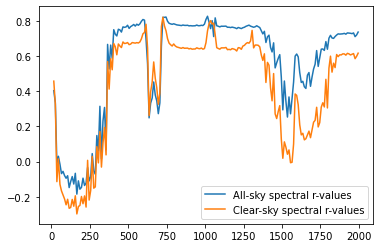

In [104]:
plt.plot(trends_reorg.wnum,np.array(rvals_list_gisstemp),label='All-sky spectral r-values')
plt.plot(trends_reorg.wnum,np.array(rvals_list_gisstemp_clr),label='Clear-sky spectral r-values')

plt.legend()

Why does the correlation structure look like this? 660 cm-1 is a strong CO2 band. 1000cm-1 is Ozone. Why better correlation in the Ozone band and the edges of the CO2 band?

If the center of the CO2 band is saturated, we might expect to see a lower correlation their, but the more complex structure is confusing for me.

Generally, the all-sky values are better predictors of surface temperature. But some clear-sky channels are nearly as good. Why?

Best all-sky correlation at 745 and 1015 cm-1. Best clear-sky correlation at 725 and 1035. Very similar.

In [106]:
rvals_gisstemp_clr

{'15.0': 0.45673565024644847,
 '25.0': 0.3259811055753904,
 '35.0': -0.11409924650026293,
 '45.0': 0.015134095798391891,
 '55.0': -0.12917137669555884,
 '65.0': -0.16675443761052208,
 '75.0': -0.18885652031330014,
 '85.0': -0.21257461085247098,
 '95.0': -0.2457116823220922,
 '105.0': -0.21442906902288683,
 '115.0': -0.265669330049675,
 '125.0': -0.2607929951747551,
 '135.0': -0.21529350273992087,
 '145.0': -0.2537874018409643,
 '155.0': -0.1945951683836108,
 '165.0': -0.2975488850377485,
 '175.0': -0.25544291678048153,
 '185.0': -0.24942645606200672,
 '195.0': -0.19855958605944785,
 '205.0': -0.2395847222495724,
 '215.0': -0.19532519529211864,
 '225.0': -0.258642130923157,
 '235.0': 0.006884308899855085,
 '245.0': -0.21885034462467592,
 '255.0': -0.16450819929500246,
 '265.0': 0.029287112158659895,
 '275.0': -0.15114020737914435,
 '285.0': -0.1440695810314559,
 '295.0': 0.08480341444379655,
 '305.0': -0.007471547778211181,
 '315.0': 0.17031694544821885,
 '325.0': -0.03145261511452971,


In [110]:
trends_745_all = trends_reorg.sel(wnum=745)
trends_1015_all = trends_reorg.sel(wnum=1015)

trends_725_clr = trends_clr_reorg.sel(wnum=725)
trends_1035_clr = trends_clr_reorg.sel(wnum=1035)

#### Visualize the spectral and temperature trends side by side.

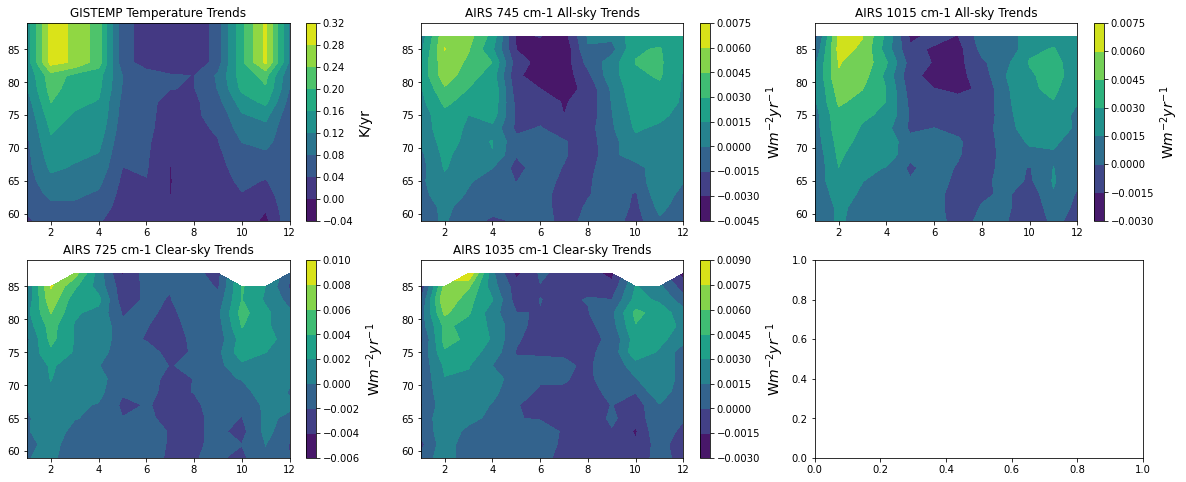

In [113]:
fig_comp,axs_comp = plt.subplots(2,3,figsize=(20,8))

axs_comp = axs_comp.flat

im0 = axs_comp[0].contourf(gisstemp_trends['month'],gisstemp_trends['lat'],gisstemp_trends.transpose('lat','month'))
cbar0 = plt.colorbar(im0,ax=axs_comp[0])
axs_comp[0].set_title('GISTEMP Temperature Trends')
cbar0.set_label(label='K/yr',fontsize=14)

im1 = axs_comp[1].contourf(trends_745_all['month'],trends_745_all['lat'],trends_745_all.transpose('lat','month'))
cbar1 = plt.colorbar(im1,ax=axs_comp[1])
axs_comp[1].set_title('AIRS 745 cm-1 All-sky Trends')
cbar1.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im2 = axs_comp[2].contourf(trends_1015_all['month'],trends_1015_all['lat'],trends_1015_all.transpose('lat','month'))
cbar2 = plt.colorbar(im2,ax=axs_comp[2])
axs_comp[2].set_title('AIRS 1015 cm-1 All-sky Trends')
cbar2.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)
# im2 = axs_comp[2].contourf(trends_1305['month'],trends_1305['lat'],trends_1305.transpose('lat','month'))
# cbar2 = plt.colorbar(im2,ax=axs_comp[2])
# axs_comp[2].set_title('AIRS 1305cm-1 Trends')
# cbar2.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im3 = axs_comp[3].contourf(trends_725_clr['month'],trends_725_clr['lat'],trends_725_clr.transpose('lat','month'))
cbar3 = plt.colorbar(im3,ax=axs_comp[3])
axs_comp[3].set_title('AIRS 725 cm-1 Clear-sky Trends')
cbar3.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im4 = axs_comp[4].contourf(trends_1035_clr['month'],trends_1035_clr['lat'],trends_1035_clr.transpose('lat','month'))
cbar4 = plt.colorbar(im4,ax=axs_comp[4])
axs_comp[4].set_title('AIRS 1035 cm-1 Clear-sky Trends')
cbar4.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

## Load NSIDC data

Using the G10010 V2 product for now.

The ancilliary data has the lat/lon point for each gridcell

In [64]:
g10010_path = '/glade/work/jonahshaw/obs/NSIDC/G10010_V2/'
g10010_file = 'G10010_sibt1850_v2.0.nc'

In [65]:
nsidc_seaice = xr.open_dataset('%s/%s' % (g10010_path,g10010_file))

In [66]:
try:
    nsidc_seaice = nsidc_seaice.rename({'latitude':'lat','longitude':'lon'})
except:
    pass

# Subset by time and latitude
g10010_tsel = nsidc_seaice.sel(time=slice('2001-01-01','2020-12-31'),lat=slice(90,59))

# Need to perform a masked and weighted average because areas are not constant and land cells must be masked
g10010_subset = masked_average(g10010_tsel['seaice_conc'],dim=['lon'],
                                      weights=g10010_tsel['Gridcell_Area'],mask=(g10010_tsel['LandRegion_mask']==20))

In [68]:
g10010_trends,g10010_statsig,g10010_notnull = compute_trends_n_signif2(g10010_subset)

123456789101112

In [70]:
g10010_interpd = g10010_trends.interp_like(all_data_spec_olr_clr['TREND'])

In [114]:
rvals_g10010 = {}
rvals_list_g10010 =[]

rvals_g10010_clr = {}
rvals_list_g10010_clr =[]

for _wnum,_wnum_clr in zip(trends_reorg,trends_clr_reorg):
    
    r = calculate_spatial_correlation(_wnum,g10010_interpd)
    r_clr = calculate_spatial_correlation(_wnum_clr,g10010_interpd)
    
    rvals_g10010[str(_wnum.wnum.values)] = r
    rvals_list_g10010.append(r)
    
    rvals_g10010_clr[str(_wnum.wnum.values)] = r_clr
    rvals_list_g10010_clr.append(r_clr)


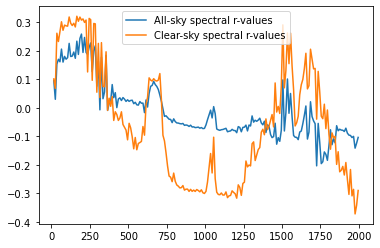

In [115]:
plt.plot(trends_reorg.wnum,np.array(rvals_list_g10010),label='All-sky spectral r-values')
plt.plot(trends_reorg.wnum,np.array(rvals_list_g10010_clr),label='Clear-sky spectral r-values')

plt.legend()

Interestingly, the correlations (i.e. predictive power) here is much worse. The negative correlating channels are just if not more useful than those with positive correlations.

Clear-sky channels correlate better with sea ice, which makes sense since clouds mask some of the affect.

In [73]:
rvals_g10010

{'15.0': 0.10163411910499164,
 '25.0': 0.06837939637262858,
 '35.0': 0.2619464589687138,
 '45.0': 0.23289672902687447,
 '55.0': 0.267264137216184,
 '65.0': 0.3021488697983318,
 '75.0': 0.2722463332562026,
 '85.0': 0.2903334788274301,
 '95.0': 0.28782256720877775,
 '105.0': 0.2867605271532019,
 '115.0': 0.3188957335429676,
 '125.0': 0.2969121922378482,
 '135.0': 0.289000297529677,
 '145.0': 0.29695552398213115,
 '155.0': 0.28394758545780585,
 '165.0': 0.3215109064250504,
 '175.0': 0.3038534876999268,
 '185.0': 0.31853294303696794,
 '195.0': 0.3080054649291395,
 '205.0': 0.31202930989706523,
 '215.0': 0.29973312158014753,
 '225.0': 0.308231781449895,
 '235.0': 0.12606742968786483,
 '245.0': 0.3138684452903819,
 '255.0': 0.3094716050478828,
 '265.0': 0.09675853670939961,
 '275.0': 0.29616660010006446,
 '285.0': 0.2947856849097581,
 '295.0': 0.055006746363332734,
 '305.0': 0.22624796910238593,
 '315.0': 0.03645170009036907,
 '325.0': 0.22892037871240833,
 '335.0': 0.07490127709271066,
 '34

Good performing all-sky channels are 195 cm-1.

Good performing clear-sky channels are 165, 1535, and 1975 cm-1.

In [118]:
trends_195_all = trends_reorg.sel(wnum=195)
trends_165_clr = trends_clr_reorg.sel(wnum=165)
trends_1535_clr = trends_clr_reorg.sel(wnum=1535)
trends_1975_clr = trends_clr_reorg.sel(wnum=1975)

#### Visualize the spectral and sea ice trends side by side.

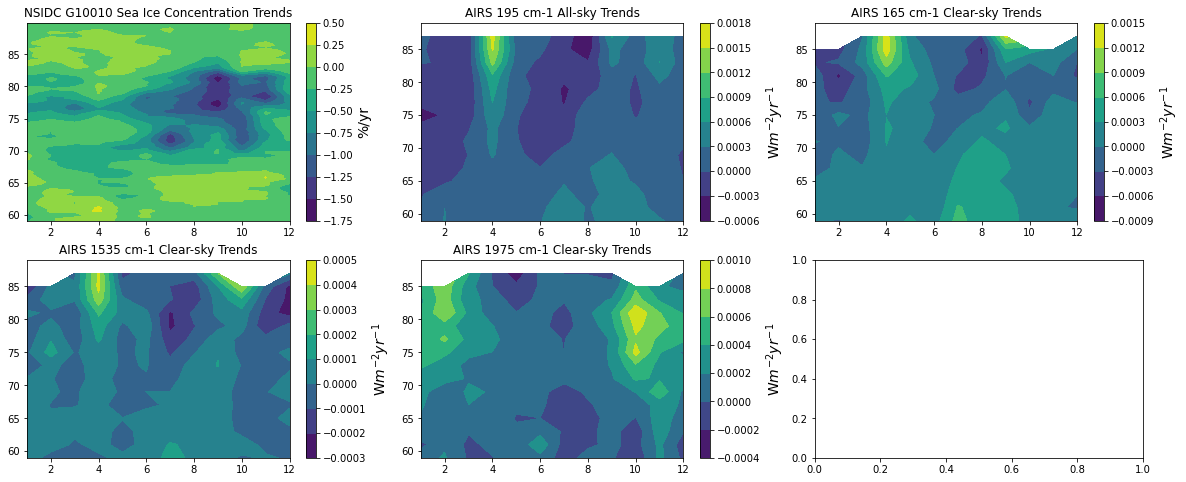

In [120]:
fig_comp,axs_comp = plt.subplots(2,3,figsize=(20,8))

axs_comp = axs_comp.flat

im0 = axs_comp[0].contourf(g10010_trends['month'],g10010_trends['lat'],g10010_trends.transpose('lat','month'))
cbar0 = plt.colorbar(im0,ax=axs_comp[0])
axs_comp[0].set_title('NSIDC G10010 Sea Ice Concentration Trends')
cbar0.set_label(label='%/yr',fontsize=14)

im1 = axs_comp[1].contourf(trends_195_all['month'],trends_195_all['lat'],trends_195_all.transpose('lat','month'))
cbar1 = plt.colorbar(im1,ax=axs_comp[1])
axs_comp[1].set_title('AIRS 195 cm-1 All-sky Trends')
cbar1.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im2 = axs_comp[2].contourf(trends_165_clr['month'],trends_165_clr['lat'],trends_165_clr.transpose('lat','month'))
cbar2 = plt.colorbar(im2,ax=axs_comp[2])
axs_comp[2].set_title('AIRS 165 cm-1 Clear-sky Trends')
cbar2.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im3 = axs_comp[3].contourf(trends_1535_clr['month'],trends_1535_clr['lat'],trends_1535_clr.transpose('lat','month'))
cbar3 = plt.colorbar(im3,ax=axs_comp[3])
axs_comp[3].set_title('AIRS 1535 cm-1 Clear-sky Trends')
cbar3.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im4 = axs_comp[4].contourf(trends_1975_clr['month'],trends_1975_clr['lat'],trends_1975_clr.transpose('lat','month'))
cbar4 = plt.colorbar(im4,ax=axs_comp[4])
axs_comp[4].set_title('AIRS 1975 cm-1 Clear-sky Trends')
cbar4.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

This confirms that these correlations are pretty meh. A shortwave spectral instrument is going to be a much more useful tool here. 

#### AIRS water vapor

This is less interesting because these products are derived from the same raw AIRS obs.

In [76]:
airs_tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

In [77]:
tmq_a_file = 'AIRS.TotH2OVap_A.200209-202012.L3.RetStd.v7.nc'
tmq_d_file = 'AIRS.TotH2OVap_D.200209-202012.L3.RetStd.v7.nc'

In [78]:
tmq_a = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_a_file))
tmq_d = xr.open_dataset('%s/%s' % (airs_tseries_dir,tmq_d_file))

tmq_a = tmq_a.rename({'TotH2OVap_A':'TotH2OVap'})
tmq_d = tmq_d.rename({'TotH2OVap_D':'TotH2OVap'})

In [79]:
_tmq_a = tmq_a['TotH2OVap'].assign_coords({'orbit':0}).expand_dims('orbit')
_tmq_d = tmq_d['TotH2OVap'].assign_coords({'orbit':1}).expand_dims('orbit')

In [80]:
tmq_both = xr.merge([_tmq_a,_tmq_d])
tmq_net = tmq_both.mean(dim='orbit')['TotH2OVap']

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [81]:
# Threw an error when the end date was 12-31
airs_tmq_subset = tmq_net.sel(time=slice('2003-01-01','2020-12-30'),lat=slice(None,58)).mean('lon')

In [83]:
wv_trends,wv_statsig,wv_notnull = compute_trends_n_signif2(airs_tmq_subset)

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [86]:
wv_interpd = wv_trends.interp_like(all_data_spec_olr_clr['TREND'])

In [121]:
rvals_wv = {}
rvals_list_wv =[]

rvals_wv_clr = {}
rvals_list_wv_clr =[]

for _wnum,_wnum_clr in zip(trends_reorg,trends_clr_reorg):
    
    r = calculate_spatial_correlation(_wnum,wv_interpd)
    r_clr = calculate_spatial_correlation(_wnum_clr,wv_interpd)
    
    rvals_wv[str(_wnum.wnum.values)] = r
    rvals_list_wv.append(r)
    
    rvals_wv_clr[str(_wnum.wnum.values)] = r_clr
    rvals_list_wv_clr.append(r_clr)


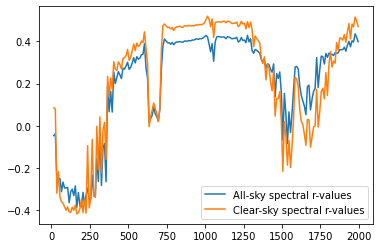

In [122]:
plt.plot(trends_reorg.wnum,np.array(rvals_list_wv),label='All-sky spectral r-values')
plt.plot(trends_reorg.wnum,np.array(rvals_list_wv_clr),label='Clear-sky spectral r-values')

plt.legend()

This looks a lot like the surface temperature correlation. The poor correlations surprise me a bit, because I'd expect the WV trends to have good channels. Clearsky is generally a better predictor than all-sky, which would make sense if clouds mask WV absorption behavior.

In [90]:
rvals_wv

{'15.0': 0.08548271016978404,
 '25.0': 0.0790657916152839,
 '35.0': -0.32021851567584014,
 '45.0': -0.2185411299078224,
 '55.0': -0.3369882439531501,
 '65.0': -0.36062527670521116,
 '75.0': -0.36795978981042254,
 '85.0': -0.3841243957497933,
 '95.0': -0.4005859880540937,
 '105.0': -0.3852788349408961,
 '115.0': -0.40887384422062556,
 '125.0': -0.4115150303730586,
 '135.0': -0.38614279013692543,
 '145.0': -0.40113642002343014,
 '155.0': -0.37591077054699396,
 '165.0': -0.4183461911309091,
 '175.0': -0.41266555354442064,
 '185.0': -0.3929696896626096,
 '195.0': -0.34717427476424034,
 '205.0': -0.41257334832391396,
 '215.0': -0.34792332099642626,
 '225.0': -0.41436620823006703,
 '235.0': -0.0945745771460392,
 '245.0': -0.38995035975396086,
 '255.0': -0.350489198780389,
 '265.0': -0.06511650793805161,
 '275.0': -0.33484812414023846,
 '285.0': -0.334795390006191,
 '295.0': -0.002260086077742049,
 '305.0': -0.20864224932595818,
 '315.0': 0.041971653706705046,
 '325.0': -0.22361694273437935,


"Good" clear-sky channels are 1015 and 1975 cm-1. Same for the all-sky channels.

In [124]:
trends_1015_all = trends_reorg.sel(wnum=1015)
trends_1975_all = trends_reorg.sel(wnum=1975)

trends_1015_clr = trends_clr_reorg.sel(wnum=1015)
trends_1975_clr = trends_clr_reorg.sel(wnum=1975)

#### Visualize the spectral and sea ice trends side by side.

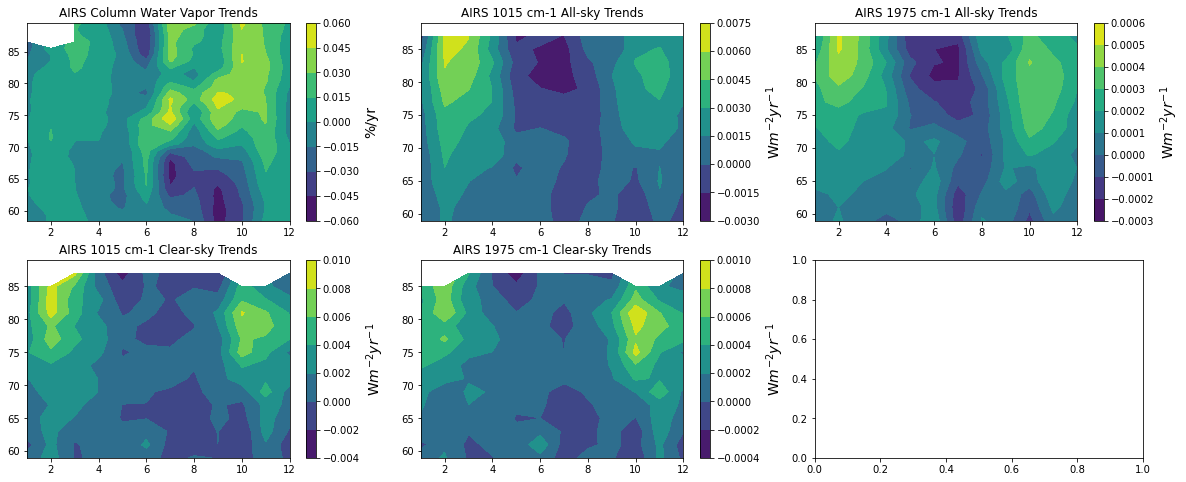

In [126]:
fig_comp,axs_comp = plt.subplots(2,3,figsize=(20,8))

axs_comp = axs_comp.flat

im0 = axs_comp[0].contourf(wv_trends['month'],wv_trends['lat'],wv_trends.transpose('lat','month'))
cbar0 = plt.colorbar(im0,ax=axs_comp[0])
axs_comp[0].set_title('AIRS Column Water Vapor Trends')
cbar0.set_label(label='%/yr',fontsize=14)

im1 = axs_comp[1].contourf(trends_1015_all['month'],trends_1015_all['lat'],trends_1015_all.transpose('lat','month'))
cbar1 = plt.colorbar(im1,ax=axs_comp[1])
axs_comp[1].set_title('AIRS 1015 cm-1 All-sky Trends')
cbar1.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im2 = axs_comp[2].contourf(trends_1975_all['month'],trends_1975_all['lat'],trends_1975_all.transpose('lat','month'))
cbar2 = plt.colorbar(im2,ax=axs_comp[2])
axs_comp[2].set_title('AIRS 1975 cm-1 All-sky Trends')
cbar2.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im3 = axs_comp[3].contourf(trends_1015_clr['month'],trends_1015_clr['lat'],trends_1015_clr.transpose('lat','month'))
cbar3 = plt.colorbar(im3,ax=axs_comp[3])
axs_comp[3].set_title('AIRS 1015 cm-1 Clear-sky Trends')
cbar3.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

im4 = axs_comp[4].contourf(trends_1975_clr['month'],trends_1975_clr['lat'],trends_1975_clr.transpose('lat','month'))
cbar4 = plt.colorbar(im4,ax=axs_comp[4])
axs_comp[4].set_title('AIRS 1975 cm-1 Clear-sky Trends')
cbar4.set_label(label='W$m^{-2}yr^{-1}$',fontsize=14)

Again, the correlation is demonstrably poor. I need to think more about this.